In [ ]:
# pip install torch

In [ ]:
# pip install scikit-learn

In [ ]:
# pip install torchvision

In [ ]:
# pip install matplotlib

In [16]:
import matplotlib.pyplot as plt

In [1]:
import shutil, random
from pathlib import Path

random.seed(42)

DATA_DIR = Path("dataset")
SPLIT_DIR = Path("data_split")
CLASSES = ["Tom", "Halvfull", "Full", "Overfull"]  # mappnamn

# skapar målmapp
for split in ["train", "val", "test"]:
    for c in CLASSES:
        (SPLIT_DIR / split / c).mkdir(parents=True, exist_ok=True)

# proportioner
train_p, val_p, test_p = 0.70, 0.15, 0.15

for c in CLASSES:
    imgs = sorted([p for p in (DATA_DIR / c).glob("*") if p.suffix.lower() in [".png", ".jpg", ".jpeg"]])
    random.shuffle(imgs)
    n = len(imgs)
    n_train = int(n * train_p)
    n_val   = int(n * val_p)
    n_test  = n - n_train - n_val

    splits = {
        "train": imgs[:n_train],
        "val":   imgs[n_train:n_train+n_val],
        "test":  imgs[n_train+n_val:]
    }
    for split, files in splits.items():
        for src in files:
            dst = SPLIT_DIR / split / c / src.name
            shutil.copy2(src, dst)

sum(len(list((SPLIT_DIR/s/c).glob("*"))) for s in ["train","val","test"] for c in CLASSES)


100

In [2]:
for split in ["train","val","test"]:
    counts = {c: len(list((SPLIT_DIR/split/c).glob("*"))) for c in CLASSES}
    print(split, counts)

train {'Tom': 17, 'Halvfull': 17, 'Full': 17, 'Overfull': 17}
val {'Tom': 3, 'Halvfull': 3, 'Full': 3, 'Overfull': 3}
test {'Tom': 5, 'Halvfull': 5, 'Full': 5, 'Overfull': 5}


In [6]:
# Resnet 18 på CPU (kan byta till grafikkort här men det gick hyfsat snabbt)
# byter till cuda senare
# förtränade vikterna från ImageNet. Ej transfer learning för MVP

import torch, torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# transforms
train_tf = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.9,1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.ToTensor()
])
eval_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

# datasets
train_ds = datasets.ImageFolder(SPLIT_DIR/"train", transform=train_tf)
val_ds   = datasets.ImageFolder(SPLIT_DIR/"val",   transform=eval_tf)
test_ds  = datasets.ImageFolder(SPLIT_DIR/"test",  transform=eval_tf)

train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=0)
val_dl   = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0)
test_dl  = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=0)

idx_to_class = {v:k for k,v in train_ds.class_to_idx.items()}
print("Klasser:", idx_to_class)

# modell
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, len(CLASSES))
model.to(device)

crit = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# träning med enkel early stopping
best_val = float("inf")
patience, bad = 5, 0

for epoch in range(30):
    model.train()
    running = 0.0
    for x,y in train_dl:
        x,y = x.to(device), y.to(device)
        opt.zero_grad()
        logits = model(x)
        loss = crit(logits, y)
        loss.backward()
        opt.step()
        running += loss.item()*x.size(0)
    train_loss = running/len(train_ds)

    # val
    model.eval()
    vloss = 0.0
    with torch.no_grad():
        for x,y in val_dl:
            x,y = x.to(device), y.to(device)
            logits = model(x)
            loss = crit(logits, y)
            vloss += loss.item()*x.size(0)
    val_loss = vloss/len(val_ds)

    print(f"Epoch {epoch+1:02d} | train {train_loss:.4f} | val {val_loss:.4f}")

    if val_loss < best_val - 1e-4:
        best_val = val_loss
        bad = 0
        torch.save(model.state_dict(), "bin_classifier_resnet18.pt")
    else:
        bad += 1
        if bad >= patience:
            print("Early stopping.")
            break

# ladda bästa
model.load_state_dict(torch.load("bin_classifier_resnet18.pt"))
model.eval()


Device: cpu
Klasser: {0: 'Full', 1: 'Halvfull', 2: 'Overfull', 3: 'Tom'}
Epoch 01 | train 1.2913 | val 3.4765
Epoch 02 | train 0.2339 | val 5.6156
Epoch 03 | train 0.2845 | val 2.3010
Epoch 04 | train 0.2051 | val 0.4698
Epoch 05 | train 0.2446 | val 0.8089
Epoch 06 | train 0.1096 | val 2.6504
Epoch 07 | train 0.1467 | val 0.1641
Epoch 08 | train 0.0548 | val 0.0644
Epoch 09 | train 0.1149 | val 0.0266
Epoch 10 | train 0.0875 | val 0.0755
Epoch 11 | train 0.1220 | val 0.0068
Epoch 12 | train 0.3217 | val 1.6307
Epoch 13 | train 0.2052 | val 0.9739
Epoch 14 | train 0.1692 | val 0.5869
Epoch 15 | train 0.1811 | val 0.3618
Epoch 16 | train 0.0880 | val 0.2471
Early stopping.


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
# prediktioner på test
all_y, all_p = [], []
with torch.no_grad():
    for x,y in test_dl:
        x = x.to(device)
        logits = model(x)
        preds = logits.argmax(1).cpu().numpy()
        all_p.extend(preds.tolist())
        all_y.extend(y.numpy().tolist())

all_y = np.array(all_y)
all_p = np.array(all_p)

print("Classification report:\n",
      classification_report(all_y, all_p, target_names=[idx_to_class[i] for i in range(len(CLASSES))]))

# Confusion matrix
cm = confusion_matrix(all_y, all_p)
print("Confusion matrix:\n", cm)

# KPI: Recall för "Töm nu" (Full + Overfull)
cls_to_idx = train_ds.class_to_idx
full_idx = cls_to_idx["Full"]
over_idx = cls_to_idx["Overfull"]
tomnu_mask = np.isin(all_y, [full_idx, over_idx])

tp = np.sum((np.isin(all_p, [full_idx, over_idx])) & tomnu_mask)
fn = np.sum((~np.isin(all_p, [full_idx, over_idx])) & tomnu_mask)
recall_tomnu = tp / (tp + fn + 1e-9)
print(f"Recall(Töm nu): {recall_tomnu:.3f}")


Classification report:
               precision    recall  f1-score   support

        Full       0.80      0.80      0.80         5
    Halvfull       0.83      1.00      0.91         5
    Overfull       1.00      0.80      0.89         5
         Tom       1.00      1.00      1.00         5

    accuracy                           0.90        20
   macro avg       0.91      0.90      0.90        20
weighted avg       0.91      0.90      0.90        20

Confusion matrix:
 [[4 1 0 0]
 [0 5 0 0]
 [1 0 4 0]
 [0 0 0 5]]
Recall(Töm nu): 0.900


*Alltså lite fel mellan full och halvfull:*
```text
Klass      Full  Halvfull  Overfull  Tom
Full         3       2        0        0
Halvfull     0       5        0        0
Overfull     0       0        5        0
Tom          0       0        0        5

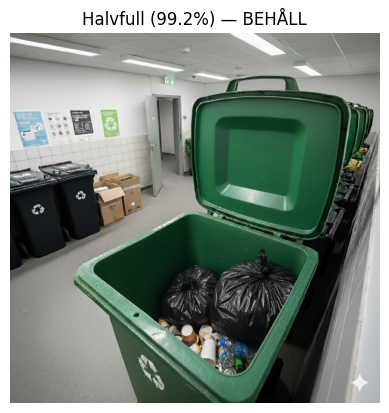

('Halvfull', 0.9918791055679321, 'BEHÅLL')

In [23]:
from PIL import Image
import torch
import torchvision.transforms as T

infer_tf = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor()])

def predict_image(path):
    img = Image.open(path).convert("RGB")
    x = infer_tf(img).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(x)
        pred = logits.argmax(1).item()
        probs = torch.softmax(logits, dim=1).squeeze().cpu().numpy()
    klass = idx_to_class[pred]
    tomnu = "TÖM NU" if klass in ["Full", "Overfull"] else "BEHÅLL"

    # visar bilden
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{klass} ({probs[pred]*100:.1f}%) — {tomnu}")
    plt.show()

    return klass, float(probs[pred]), tomnu


# test på osedd testdata
predict_image("data_split/test/test_bland/Gemini_Generated_Image_1shuiw1shuiw1shu.png")